In [37]:
import os
import math
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib import cm
from scipy import stats
from scipy import optimize
from scipy import integrate
import scipy.linalg as la
import numpy.polynomial.polynomial as poly
from bisect import bisect_left
import pprint

In [38]:
def import_file(path, limit_low=None, limit_high=None):

    spectrum = np.genfromtxt(path, delimiter=",")
    spectrum = np.transpose(spectrum)
    wavenumbers = spectrum[0]
    intensities = spectrum[1]

    if limit_low is not None:
        limit_low_index = list(wavenumbers).index(limit_low)
    else:
        limit_low_index = 0
        limit_low = wavenumbers[0]

    if limit_high is not None:
        limit_high_index = list(wavenumbers).index(limit_high)
    else:
        limit_high_index = len(wavenumbers)
        limit_high = wavenumbers[-1]

    wavenumbers = wavenumbers[limit_low_index:limit_high_index]
    intensities = intensities[limit_low_index:limit_high_index]
    return wavenumbers, intensities

def import_directory(path, limit_low=None, limit_high=None):
    if not path.endswith("/"):
        path = path + "/"
    
    files = os.listdir(path)
    files = [file for file in files if file.lower().endswith(".txt")]
    
    #files = sorted(files, key=lambda s: int(s[s.find("(")+1:s.find(")")]))
    
    
    wavenumbers = []
    intensities = []
        
    for file in files:
        wns, ints = import_file(path + file, limit_low, limit_high)
        wavenumbers.append(wns)
        intensities.append(ints)
    return np.array(wavenumbers), np.array(intensities), files

In [39]:
wavenumbers, intensities, files = import_directory(r"C:\Users\Daniel\Desktop\spectra_qc\NPs\Ag2_2_txt")

In [40]:
##################################
# Parameters for 4S Peak Filling #
##################################

penalty = 2         # Smoothing strength, starting value: 4
half_width = 8      # Half width of suppression window, starting value: half width at half height of widest peak
iterations = 5     # Number of iterations of the suppression cycle, starting value: 10
buckets = 500       # Number of intervals the data is divided into, can also be an array of indices, starting value: 1/10 of the number of data points

In [41]:
dims = np.shape(intensities)
baseline = np.zeros(dims)
corrected = np.zeros(dims)

In [42]:
#############
# Smoothing #
#############

diag = np.zeros((5,5))
np.fill_diagonal(diag, 1)
middle = np.matmul(np.diff(diag, n=2, axis=0).T, np.diff(diag, n=2, axis=0))
zeros = np.zeros((2,5))

to_band = np.vstack((zeros, middle, zeros))
the_band = np.diag(to_band)

for i in range(1, 5):
    the_band = np.vstack((the_band, np.diag(to_band, -i)))
    
indices = [0,1] + [2] * (dims[1]-4) + [3,4]
dd = the_band[:, indices] * (10**penalty)
dd[2,] = dd[2,] + 1

ints_original = intensities[:,:]
intensities = la.solve_banded((2,2), dd, intensities.T).T
dd

array([[   0.,    0.,  100., ...,  100.,  100.,  100.],
       [   0., -200., -400., ..., -400., -400., -200.],
       [ 101.,  501.,  601., ...,  601.,  501.,  101.],
       [-200., -400., -400., ..., -400., -200.,    0.],
       [ 100.,  100.,  100., ...,  100.,    0.,    0.]])

In [43]:
fig, ax = plt.subplots()
ax.plot(wavenumbers[0], ints_original[0], linewidth=1)
ax.plot(wavenumbers[0], intensities[0], linewidth=1)
ax.set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))

(280.0, 1740.0)

In [44]:
if iterations != 1:
    d1 = math.log10(half_width)
    d2 = 0

    tmp = np.array(range(iterations-1)) * (d2 - d1) / (iterations - 1) + d1
    tmp = np.append(tmp, d2)
    w = np.ceil(10**tmp).astype(int)
else:
    w = np.array((half_width))

w

array([8, 5, 3, 2, 1])

In [45]:
if isinstance(buckets, int):
    lims = np.linspace(0, dims[1]-1, buckets+1, dtype=int)
else:
    lims = buckets
    buckets = len(lims)-1
    
mids = np.rint(np.convolve(lims, np.ones(2), 'valid') / 2).astype(int)
mids[0] = 0
mids[-1] = dims[1]-1

In [46]:
%matplotlib
for s in range(dims[0]):
    
    ###############
    # Subsampling #
    ###############
    
    xx = np.zeros(buckets)
    for i in range(buckets):
        xx[i] = np.min(intensities[s, lims[i]:lims[i+1]])
        
    ###############
    # Suppression #
    ###############
    
    if s == 0:
        fig, ax = plt.subplots()
        ax.plot(wavenumbers[0], ints_original[0])
        ax.set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))
        ax.invert_xaxis()
        ax.set_xlabel("Wavenumber [cm^-1]")
        ax.set_ylabel("Intensity")
        
    
    for i in range(iterations):
        w0 = w[i]
        
        for j in range(1, buckets):
            v = min(j, w0, buckets-j)
            a = np.mean(xx[j-v:j+v+1])
            xx[j] = min(a, xx[j])
            
        if s == 0:
            ax.plot(wavenumbers[0, mids], xx, linewidth=0.5)
            
        for j in range(buckets-1, 0, -1):
            v = min(j, w0, buckets-j)
            a = np.mean(xx[j-v:j+v+1])
            xx[j] = min(a, xx[j])
        
        if s == 0:
            ax.plot(wavenumbers[0, mids], xx, linewidth=0.5)
            
    ##############
    # Stretching #
    ##############
        
    xxx = np.interp(range(dims[1]), mids, xx)
    baseline[s] = xxx
    corrected[s] = ints_original[s] - baseline[s]

Using matplotlib backend: Qt5Agg


In [120]:
corrected_sg2 = sig.savgol_filter(x=corrected,
                                  window_length=35,
                                  polyorder=3,
                                  deriv=2)

peaks = []
peaks_height = []
for i, row in enumerate(corrected_sg2):
    threshold = 0.05
#     print(i, threshold)
    peaks_tmp = sig.argrelmin(row)[0]
    peaks_tmp = [peak for peak in peaks_tmp if row[peak] < -threshold]
    
    peak_condensing = []
    peaks_tmp2 = []
    for j in range(len(row)):
        if j in peaks_tmp:
            peak_condensing.append(j)
        if row[j] > 0 and len(peak_condensing) > 0:
            peaks_tmp2.append(int(np.mean(peak_condensing)))
            peak_condensing = []
    if len(peak_condensing) > 0:
        peaks_tmp2.append(int(np.mean(peak_condensing)))
    
    heights = [corrected[i, k] for k in peaks_tmp2]
    
    peaks.append(peaks_tmp2)
    peaks_height.append(heights)
    

In [121]:
n_peaks = [len(row) for row in peaks]
total_areas = integrate.simpson(corrected, wavenumbers)
avg_area = [area/n for n, area in zip(n_peaks, total_areas)]
median_height = [np.median(row) for row in peaks_height]
avg_height = [np.mean(row) for row in peaks_height]

In [106]:
print("index\tn_peaks\ttotal_area\tavg_area\tmedian_height\tavg_height")
for i in range(len(corrected)):
    print(f"{i}\t{n_peaks[i]}\t{int(total_areas[i])}\t\t{int(avg_area[i])}\t\t{int(median_height[i])}\t\t{int(avg_height[i])}")

index	n_peaks	total_area	avg_area	median_height	avg_height
0	26	2483418		95516		2079		6108
1	28	2928512		104589		1931		6645
2	28	1814029		64786		1195		3937
3	30	5481908		182730		3357		11140
4	33	8633255		261613		4115		16434
5	28	2890678		103238		1908		6206
6	28	1979159		70684		1371		4168
7	23	1379443		59975		1206		3547
8	32	18925387		591418		9430		35648
9	29	7421037		255897		5572		16208
10	30	6667822		222260		4978		14311
11	33	11871406		359739		5294		21802
12	23	1730280		75229		1385		4600
13	33	19407352		588101		9336		36130
14	28	3052758		109027		1858		6167
15	15	1301419		86761		2890		2938
16	18	784317		43573		1347		2295
17	33	14824057		449213		6987		28261
18	27	1661033		61519		1088		2907
19	13	859730		66133		1807		2118
20	10	734961		73496		1501		1767
21	33	17594133		533155		7684		32978
22	32	9057632		283051		4582		17099
23	32	6308142		197129		3584		12480
24	15	472477		31498		1081		1739
25	15	647840		43189		2056		2102
26	31	16490076		531937		9754		31831
27	32	8767159		273973		4933		168

In [122]:
%matplotlib

for i in range(len(corrected)):

    fig, ax = plt.subplots(2)

    ax[0].plot(wavenumbers[i,], corrected[i,], linewidth=1)
    ax[0].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
    ax[0].invert_xaxis()
    ax[0].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
    ax[0].vlines(wavenumbers[i,peaks[i]], 0, np.max(corrected[i])*1.1, color="red", linewidth=0.5)
    ax[0].grid()


    ax[1].plot(wavenumbers[i,], corrected_sg2[i,], linewidth=1)
    ax[1].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
    ax[1].invert_xaxis()
    ax[1].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
    ax[1].grid()

Using matplotlib backend: Qt5Agg


<ipython-input-122-574e639a55a5>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


In [52]:
%matplotlib

for i in range(len(corrected)):

    fig, ax = plt.subplots(2)
    ax[0].plot(wavenumbers[i,], ints_original[i,], linewidth=1)
    ax[0].plot(wavenumbers[i,], baseline[i,], linewidth=1)
    ax[0].set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))
    ax[0].invert_xaxis()
    ax[0].grid()


    ax[1].plot(wavenumbers[i,], corrected[i,], linewidth=1)
    ax[1].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
    ax[1].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
    ax[1].vlines(wavenumbers[i,peaks[i]], 0, np.max(corrected[i])*1.1, color="red", linewidth=0.5)
    ax[1].invert_xaxis()
    ax[1].grid()
    
    fig.suptitle(files[i])

Using matplotlib backend: Qt5Agg


<ipython-input-52-f0d41b101e83>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


In [123]:
fig, ax = plt.subplots(figsize=(10,5.7))

ax.plot(wavenumbers[1,], corrected[1,], linewidth=1)
ax.set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
ax.invert_xaxis()
ax.hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
for p in peaks[1]:
    ax.vlines(wavenumbers[1,p], 0, corrected[1,p]+2000, color="red", linewidth=0.5)
ax.grid()
ax.set_xlabel(r"Raman Shift [$cm^{-1}$]")
ax.set_ylabel("Intensity [-]")
plt.tight_layout()

In [124]:
fig, ax = plt.subplots(figsize=(10,5.7))

ax.plot(wavenumbers[1,], corrected[1,], linewidth=1)
ax.set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
ax.invert_xaxis()
ax.hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
ax.vlines(wavenumbers[1,peaks[1]], 0, np.max(corrected[1])*1.1, color="red", linewidth=0.5)
ax.grid()
ax.set_xlabel(r"Raman Shift [$cm^{-1}$]")
ax.set_ylabel("Intensity [-]")
plt.tight_layout()

In [22]:
files_by_total_area = [file for area, file in sorted(zip(total_areas, files))]
files_by_avg_area = [file for area, file in sorted(zip(avg_area, files))]
files_by_median_height = [file for height, file in sorted(zip(median_height, files))]
files_by_avg_height = [file for height, file in sorted(zip(avg_height, files))]
files_by_n_peaks = [file for n, file in sorted(zip(n_peaks, files))]

total_area_x_n_peaks = [n*area for n, area in zip(n_peaks, total_areas)]
files_by_area_x_peaks = [file for score, file in sorted(zip(total_area_x_n_peaks, files))]

avg_area_exp_peaks = [area**n for n, area in zip(n_peaks, avg_area)]
files_by_area_exp_peaks = [file for score, file in sorted(zip(avg_area_exp_peaks, files))]

avg_height_exp_peaks = [height**n for n, height in zip(n_peaks, avg_height)]
files_by_height_exp_peaks = [file for score, file in sorted(zip(avg_height_exp_peaks, files))]

median_height_exp_peaks = [height**n for n, height in zip(n_peaks, median_height)]
files_by_med_height_exp_peaks = [file for score, file in sorted(zip(median_height_exp_peaks, files))]

In [23]:
files_by_total_area

['EXTRACT_9.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_1.TXT']

In [24]:
files_by_avg_area

['EXTRACT_9.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_1.TXT']

In [25]:
files_by_median_height

['EXTRACT_9.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_1.TXT']

In [26]:
files_by_avg_height

['EXTRACT_9.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_1.TXT']

In [27]:
files_by_n_peaks

['EXTRACT_17.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_1.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_9.TXT',
 'EXTRACT_12.TXT']

In [28]:
files_by_area_x_peaks

['EXTRACT_9.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_1.TXT']

In [29]:
files_by_area_exp_peaks

['EXTRACT_17.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_9.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_1.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT']

In [30]:
files_by_height_exp_peaks

['EXTRACT_17.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_7.TXT',
 'EXTRACT_9.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_1.TXT',
 'EXTRACT_6.TXT']

In [31]:
files_by_med_height_exp_peaks

['EXTRACT_7.TXT',
 'EXTRACT_17.TXT',
 'EXTRACT_2.TXT',
 'EXTRACT_9.TXT',
 'EXTRACT_13.TXT',
 'EXTRACT_10.TXT',
 'EXTRACT_14.TXT',
 'EXTRACT_11.TXT',
 'EXTRACT_15.TXT',
 'EXTRACT_3.TXT',
 'EXTRACT_12.TXT',
 'EXTRACT_18.TXT',
 'EXTRACT_0.TXT',
 'EXTRACT_16.TXT',
 'EXTRACT_5.TXT',
 'EXTRACT_4.TXT',
 'EXTRACT_8.TXT',
 'EXTRACT_19.TXT',
 'EXTRACT_6.TXT',
 'EXTRACT_1.TXT']

In [6]:
?

Object `plt.axes.Axes.tick_params` not found.


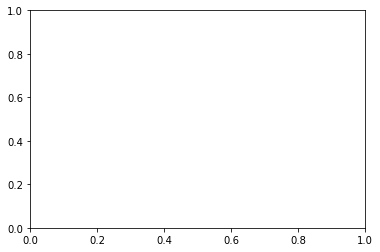

In [5]:
fig, ax = plt.subplots()
ax.set_yl

In [30]:
[npeaks for scores, npeaks in sorted(zip([],[]))]

[]

In [13]:
wavenumbers

array([[ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ],
       [ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ],
       [ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ],
       ...,
       [ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ],
       [ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ],
       [ 280. ,  280.5,  281. , ..., 1739. , 1739.5, 1740. ]])